# Getting started with the Intertidal Extents Relative Model and ITEM Confidence (ITEM v2.0)

**What does this notebook do?** 

This notebook provides an introduction to the DEA Intertidal Extents Relative Model (ITEM v2.0), which analyses GA's historic archive of satellite imagery to derive a model of the spatial extents of the intertidal zone throughout the tidal cycle. The model can assist in understanding the relative elevation profile of the intertidal zone, delineating exposed areas at differing tidal heights and stages.

**Required inputs**

None. If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

## Import modules

In [3]:
import os
import sys
import datacube
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Create datacube instance
dc = datacube.Datacube(app='ITEM')

## Overview of ITEM v2.0 products

The DEA Intertidal Extents Relative Model product is a national scale gridded dataset characterising the spatial extents of the exposed intertidal zone, at intervals of the observed tidal range (Sagar et al. 2017). The current version (2.0) utilises all Landsat observations (5, 7, and 8) for Australian coastal regions (excluding off-shore Territories) between 1986 and 2016 (inclusive).

ITEM v2.0 has implemented an improved tidal modelling framework (see Sagar et al. 2018) over that utilised in ITEM v1.0. The expanded Landsat archive within the Digital Earth Australia (DEA) has also enabled the model extent to be increased to cover a number of offshore reefs, including the full Great Barrier Reef and southern sections of the Torres Strait Islands. The DEA archive and new tidal modelling framework has improved the coverage and quality of the ITEM v2.0 relative extents model, particularly in regions where AGDC cell boundaries in ITEM v1.0 produced discontinuities or the imposed v1.0 cell structure resulted in poor quality tidal modelling (see Sagar et al. 2017).

Two ITEM v2.0 datasets are available through DEA: the ITEM v2.0 relative tidal extents layer, and the ITEM v2.0 confidence layer. Both layers are in the Australian Albers `EPSG:3577` projection system, and have 25m pixel resolution:

In [4]:
# List metadata for ITEM products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
display(dc_products[dc_products.product_type == 'ITEM'][display_columns].set_index('name'))

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
item_v2,Intertidal Extents Model,ITEM,EPSG:3577,"[-25, 25]","(y, x)"
item_v2_conf,Average ndwi Standard Deviation,ITEM,EPSG:3577,"[-25, 25]","(y, x)"


## Import ITEM Relative Extent Model
We can set up an extraction query for ITEM using only spatial details (i.e. extent and projection): because it was computed by combining the entire Landsat time series into a single layer, ITEM has no true temporal dimension (the layers do have a timestamp `2001-06-01T23:59:59.500000`, but this is a meaningless placeholder value which is only required due to restrictions of the netCDF file format).

In [5]:
# Set up analysis data query using a buffer around a lat-long point
lat, lon = -18.2066466248, 122.214634558
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 8000, x + 8000),
         'y': (y - 8000, y + 8000),         
         'crs': 'EPSG:3577'}

# Import ITEM v2.0 relative layer 
item_data = dc.load(product = 'item_v2', **query)

# Squeeze out the unnecessary temporal dimension:
item_data = item_data.squeeze(dim = 'time', drop = True)
print(item_data)

<xarray.Dataset>
Dimensions:   (x: 641, y: 641)
Coordinates:
  * y         (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x         (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 -1.041e+06 ...
Data variables:
    relative  (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577


### Plot ITEM relative extents layer
We can now plot the ITEM Relative Extent Model. The resulting plot will show a set of eight 'tidal intervals' (from `1` to `8`) that run roughly parallel to the shoreline: each interval delineates areas of intertidal terrain that were exposed at differing tidal heights and stages. Starting at the lowest interval `1` (deep red),  each interval represents a 10% portion of the tidal range observed by the Landsat satellite across the entire 30 year (1986-2016) time series. Interval `1` is only exposed during the lowest of observed tides, while interval `8` (deep blue) is exposed during all but the highest observed tides.

The data also includes two non-intertidal values: `0`, which marks areas that were inundated with water in every landsat observation, and `9`, which marks pixels that contained dry land during every Landsat observation. 

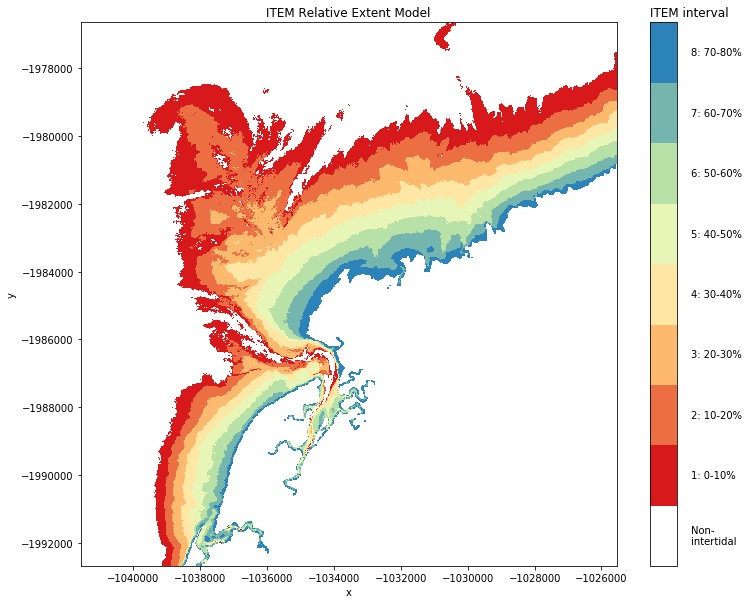

In [6]:
# Set up colour schemes and plot labels
item_cs = ['white', '#d7191c', '#ec6e43', '#fdb96e', '#fee7a4', 
           '#e7f5b7', '#b7e1a7', '#74b6ad', '#2b83ba', 'white']
labels = ['Non-\nintertidal', '1: 0-10%', '2: 10-20%', '3: 20-30%', 
          '4: 30-40%', '5: 40-50%', '6: 50-60%', '7: 60-70%', '8: 70-80%']

# Plot ITEM Relative Extent Model
item_plot = item_data.relative.plot(figsize=(12, 10), levels=10, colors=item_cs, add_colorbar=False)
plt.title('ITEM Relative Extent Model')

# Add tidal interval percentages to colorbar
cbar = plt.colorbar(item_plot)
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.set_title('ITEM interval', loc = 'left')

for j, label in enumerate(labels):
    cbar.ax.text(1.5, (j + 0.5) / 9.0, label, ha='left', va='center', color='black')
cbar.ax.get_yaxis().labelpad = 15

### How ITEM intervals correspond to Landsat observations and tidal heights
Because ITEM Relative Extent Model intervals represent a *relative* 10% proportion of the tidal range observed by Landsat across a 30 year period, they represent different ranges of tidal heights in different locations around Australia's coastline. The plot below assists in interpreting what each interval represents: coloured bars correspond to the coloured intervals above, and show the Landsat observations (black dots) and the range of tidal heights (y-axis) that were used to generate each interval. For example, the bright red interval above (interval `1` or 0-10% of observed tide heights) was produced using Landsat observations that were acquired during tides of between -2.25 to -3.0m below Mean Sea Level (MSL). These plots are [available for all areas of Australia's coastline by clicking on an ITEM polygon on National Map](https://nationalmap.gov.au/#share=s-z67A2BRZUYCcbOtc2kWvTcgjWTq).

<div class="alert alert-info">
<b>An important thing to remember when interpreting ITEM relative extents:</b> Due the sun-synchronous nature of the various Landsat sensor observations, it is unlikely that the full physical extents of the tidal range are observed by Landsat. Hence, the highest and lowest *observed* tidal heights used to produce the intervals can cover a variable proportion of the full tidal range, and have no consistent relationship to Lowest and Highest Astronomical Tide. For example, observe how the top and bottom of the coloured bars below do not match up with the top and bottom of the full light grey tidal range:
</div>

![image](http://dea-public-data.s3-ap-southeast-2.amazonaws.com/ITEM_Intervals/ITEM_REL_209_122.20_-18.07.jpg)

## Import ITEM Confidence layer
The Confidence layer is designed to assess the reliability of the Relative Extent Model. Within each tidal range percentile interval, the pixel-based standard deviation of the NDWI values for all observations in the interval subset is calculated. The average standard deviation across all tidal range intervals is then calculated and retained as a quality indicator in this product layer:

In [7]:
# Import ITEM v2.0 confidence and plot
conf_data = dc.load(product = 'item_v2_conf', **query)

# Squeeze out the unnecessary temporal dimension:
conf_data = conf_data.squeeze(dim = 'time', drop = True)
print(conf_data)


<xarray.Dataset>
Dimensions:  (x: 641, y: 641)
Coordinates:
  * y        (y) float64 -1.977e+06 -1.977e+06 -1.977e+06 -1.977e+06 ...
  * x        (x) float64 -1.042e+06 -1.042e+06 -1.042e+06 -1.041e+06 ...
Data variables:
    stddev   (y, x) float32 0.17464234 0.17408775 0.17394097 0.17444624 ...
Attributes:
    crs:      EPSG:3577


### Plot ITEM Confidence layer
The Confidence layer reflects the pixel based consistency of the NDWI values within each subset of observations, based on the tidal range. Higher standard deviation values (orange to red colours below) indicate water classification changes not based on the tidal cycle, and hence lower confidence in the extent model. Possible drivers of these changes include:

* Inadequacies of the tidal model, due perhaps to complex coastal bathymetry or estuarine structures not captured in the model. These effects have been reduced in ITEM v2.0 compared to previous versions, through the use of an improved tidal modelling framework
* Change in the structure and exposure of water/non-water features NOT driven by tidal variation. For example, movement of sand banks in estuaries, construction of man-made features (ports etc.).
* Terrestrial/Inland water features not influenced by the tidal cycle.

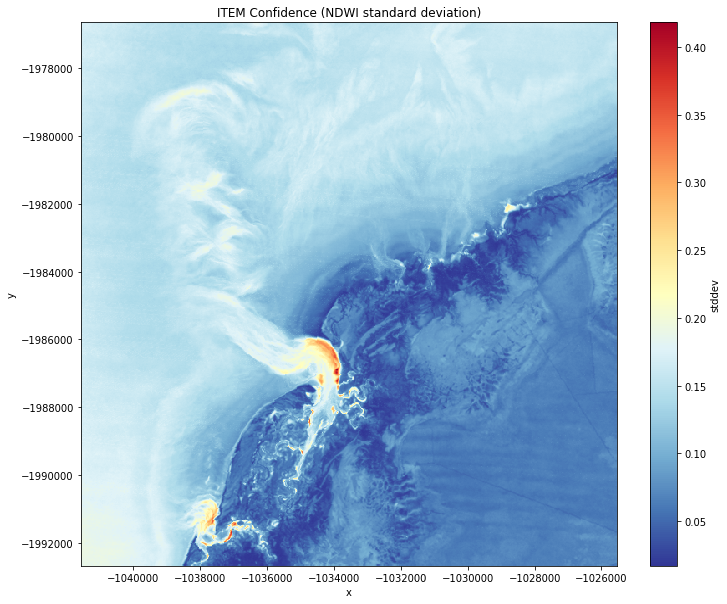

In [8]:
# Plot ITEM Confidence
conf_data.stddev.plot(figsize=(12, 10), cmap='RdYlBu_r')
plt.title('ITEM Confidence (NDWI standard deviation)');

## Masking out ITEM Relative Extents Model with ITEM Confidence
Because areas with high ITEM Confidence values indicate areas where the ITEM Relative Extents Model is likely to be invalid, a common workflow is to use the Confidence layer to mask out areas of high NDWI standard deviation. The specific value used to mask the layer will depend on the study area and application; a cutoff of 0.25 is typically a good place to start:

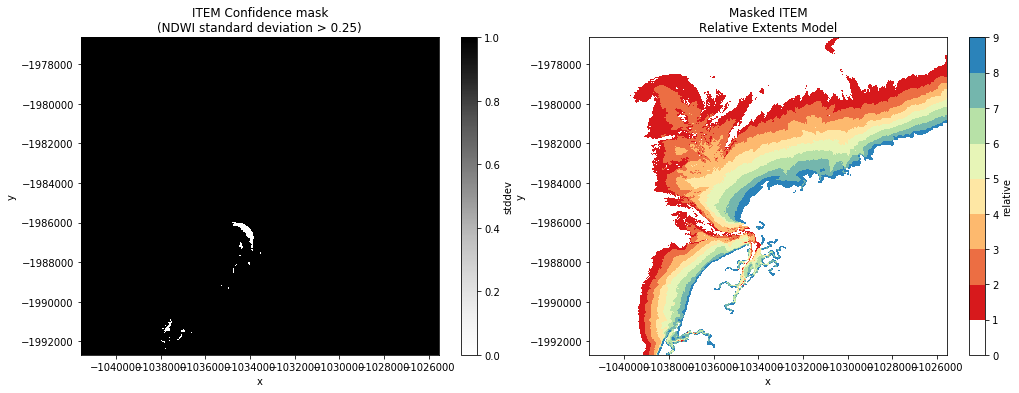

In [9]:
# Create boolean mask that is True where ITEM Confidence NDWI standard deviation is less than 0.25:
conf_mask = conf_data.stddev < 0.25

# Mask out pixels with high NDWI standard deviation (mask == False)
item_masked = item_data.where(conf_mask)

# Plot mask and masked ITEM Relative Extents layer
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
fig.tight_layout(w_pad=3)
conf_mask.plot(cmap = 'Greys', ax=axes[0])
axes[0].title.set_text('ITEM Confidence mask\n(NDWI standard deviation > 0.25)')
item_masked.relative.plot(levels=10, colors=item_cs, ax=axes[1])
axes[1].title.set_text('Masked ITEM\nRelative Extents Model')